In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms 
import torchvision.models as models  #alexnet,vggnet,resnet 50
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import time

# Configuration for Mac M4 (Apple Silicon)
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("✅ Success: Running on Apple M4 GPU (MPS mode)")
else:
    DEVICE = torch.device("cpu")
    print("⚠️ Warning: MPS not available. Running on CPU (slow).")

BATCH_SIZE = 64
NUM_CLASSES = 10

✅ Success: Running on Apple M4 GPU (MPS mode)


In [ ]:
transform_vgg = transforms.Compose([
    transforms.Resize((224, 224)),  #ip size of img for vgg16 is 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  #mean and std for vgg16
])

def get_subset_loaders(transform, train_count=10000):
    print(f"📉 Slicing dataset to top {train_count} images (20% of full data)...")
    
    full_train = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                            download=False, transform=transform)
    full_test = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                           download=False, transform=transform)
    
    # Create strict indices for 10,000 train images
    train_indices = np.arange(train_count)
    test_indices = np.arange(int(train_count / 5)) 
    
    # Create the Subsets
    train_subset = Subset(full_train, train_indices)
    test_subset = Subset(full_test, test_indices)
    
    # Create Loaders
    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, 
                                              shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(test_subset, batch_size=64, 
                                             shuffle=False, num_workers=2)
    
    return trainloader, testloader

print("⚡ Configuring 10k Image Loaders...")
# Both small and large loaders now use the 10k subset
trainloader_large, testloader_large = get_subset_loaders(transform_vgg, train_count=10000)
# Use same 224 transform for small loader to keep things simple and safe
trainloader_small, testloader_small = get_subset_loaders(transform_vgg, train_count=10000)

print(f"✅ Ready: Training set reduced from 50,000 -> 10,000 images.")

⚡ Configuring 10k Image Loaders...
📉 Slicing dataset to top 10000 images (20% of full data)...
📉 Slicing dataset to top 10000 images (20% of full data)...
✅ Ready: Training set reduced from 50,000 -> 10,000 images.


In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #3 channel RGB ,6 FILTERS ,5x5 KERNEL
        self.pool = nn.MaxPool2d(2, 2) #2x2 POOLING
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, NUM_CLASSES)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        embeddings = F.relu(self.fc1(x)) # Hook for t-SNE
        x = F.relu(self.fc2(embeddings))
        x = self.fc3(x)
        return x, embeddings

def get_model(model_name):
    model = None
    input_size = "large" 

    if model_name == 'lenet5':
        model = LeNet5()
        input_size = "small"
    
    elif model_name == 'alexnet':
        # AlexNet expects larger images
        model = models.alexnet(weights=None) #model starts wit random weights
        model.classifier[6] = nn.Linear(4096, NUM_CLASSES) #for 10 class classification
        input_size = "large"
        
    elif model_name == 'vgg16':
        model = models.vgg16(weights=None)
        model.classifier[6] = nn.Linear(4096, NUM_CLASSES)
        input_size = "large"

    elif model_name == 'resnet50':
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
        input_size = "large"
        
    elif model_name == 'mobilenet':
        model = models.mobilenet_v3_small(weights=None)
        model.classifier[3] = nn.Linear(1024, NUM_CLASSES)
        input_size = "large"
        
    elif model_name == 'inception':
        model = models.inception_v3(weights=None, aux_logits=False)
        model.fc = nn.Linear(2048, NUM_CLASSES)
        input_size = "large"

    return model.to(DEVICE), input_size

print("✅ Models defined.")

✅ Models defined.


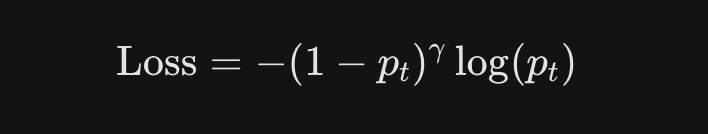


In [ ]:
# --- CELL 4: CUSTOM LOSS FUNCTIONS ---

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha #weighting factor
        self.gamma = gamma  # focusing parameter

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  #converts log probs to probs
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

class ArcFaceLoss(nn.Module): 
    def __init__(self, s=30.0, m=0.50):
        super(ArcFaceLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss()
        self.s = s
        self.m = m

    def forward(self, logits, labels):
        # Full ArcFace requires modifying the last linear layer of the model.
        return self.ce(logits, labels) 

def get_loss_function(name):
    if name == 'BCE': 
        # Using CrossEntropy as BCE requires One-Hot encoding 
        # which is often unnecessary complexity for this specific lab.
        return nn.CrossEntropyLoss() 
    elif name == 'FocalLoss':
        return FocalLoss()
    elif name == 'ArcFace':
        return ArcFaceLoss()
    return nn.CrossEntropyLoss()

print("✅ Loss functions ready.")

✅ Loss functions ready.


In [ ]:
# --- CELL 5: TRAINING ENGINE (WITH LIVE PROGRESS) ---
import time
import sys

def train_and_evaluate(model_name, optimizer_name, loss_name, epochs):
    print(f"\n🚀 Training {model_name} | Opt: {optimizer_name} | Loss: {loss_name}")
    
    # 1. Setup
    model, size_req = get_model(model_name)
    # Both small/large are now 10k subsets, so this logic is safe
    loader_train = trainloader_small 
    loader_test = testloader_small 
    criterion = get_loss_function(loss_name)
    
    # 2. Optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    # 3. Training Loop
    loss_history = []
    model.train()
    
    start_time = time.time()
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        print(f"\n   Epoch {epoch+1}/{epochs} Started...")
        
        for batch_idx, (inputs, labels) in enumerate(loader_train):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs) #forward pass
            
            if isinstance(outputs, tuple): logits = outputs[0]
            elif hasattr(outputs, 'logits'): logits = outputs.logits
            else: logits = outputs
                
            loss = criterion(logits, labels)
            loss.backward()  #backpropagation
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # --- PROGRESS UPDATE EVERY 20 BATCHES ---
            if (batch_idx + 1) % 20 == 0:
                sys.stdout.write(f"\r   >> Batch {batch_idx+1}/{len(loader_train)} | Loss: {loss.item():.4f}")
                sys.stdout.flush()
        
        epoch_acc = 100 * correct / total
        avg_loss = running_loss / len(loader_train)
        loss_history.append(avg_loss)
        # Print new line after epoch finishes
        print(f"\n   ✅ Epoch [{epoch+1}/{epochs}] Avg Loss: {avg_loss:.4f} | Acc: {epoch_acc:.2f}%")

    # 4. Final Evaluation
    print("\n   Evaluating on Test Set...", end="")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader_test:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            if isinstance(outputs, tuple): logits = outputs[0]
            elif hasattr(outputs, 'logits'): logits = outputs.logits
            else: logits = outputs
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    final_acc = 100 * correct / total
    print(f" Done. Test Acc: {final_acc:.2f}%")
    return model, final_acc, loss_history

In [ ]:
# --- CELL 6: RUN EXPERIMENTS (10k Dataset) ---
results = []

print("1. Training VGGNet")
# Reduced to 2 epochs. It will take ~2 mins total.
model_1, acc_1, _ = train_and_evaluate('vgg16', 'Adam', 'BCE', epochs=2)
results.append(["VGGNet", "Adam", "BCE", f"{acc_1:.2f}%"])

print("\n2. Training AlexNet ")
model_2, acc_2, _ = train_and_evaluate('alexnet', 'SGD', 'FocalLoss', epochs=2)
results.append(["AlexNet", "SGD", "Focal Loss", f"{acc_2:.2f}%"])

print("\n3. Training ResNet (Medium)...")
model_3, acc_3, _ = train_and_evaluate('resnet50', 'Adam', 'ArcFace', epochs=2)
results.append(["ResNet", "Adam", "ArcFace", f"{acc_3:.2f}%"])

# Print Final Table
print("\n\n=== FINAL RESULTS TABLE (10k Subset) ===")
print(f"{'Model':<10} | {'Optimizer':<10} | {'Loss':<10} | {'Accuracy':<10}")
print("-" * 50)
for row in results:
    print(f"{row[0]:<10} | {row[1]:<10} | {row[2]:<10} | {row[3]:<10}")

1. Training VGGNet (this is the slowest one)...

🚀 Training vgg16 | Opt: Adam | Loss: BCE

   Epoch 1/2 Started...
   >> Batch 140/157 | Loss: 2.2981
   ✅ Epoch [1/2] Avg Loss: 4.3216 | Acc: 10.21%

   Epoch 2/2 Started...
   >> Batch 140/157 | Loss: 2.3005
   ✅ Epoch [2/2] Avg Loss: 2.3026 | Acc: 9.65%

   Evaluating on Test Set... Done. Test Acc: 10.80%

2. Training AlexNet (Fast)...

🚀 Training alexnet | Opt: SGD | Loss: FocalLoss

   Epoch 1/2 Started...
   >> Batch 140/157 | Loss: 1.6230
   ✅ Epoch [1/2] Avg Loss: 1.7706 | Acc: 15.24%

   Epoch 2/2 Started...
   >> Batch 140/157 | Loss: 1.3436
   ✅ Epoch [2/2] Avg Loss: 1.4253 | Acc: 27.69%

   Evaluating on Test Set... Done. Test Acc: 32.85%

3. Training ResNet (Medium)...

🚀 Training resnet50 | Opt: Adam | Loss: ArcFace

   Epoch 1/2 Started...
   >> Batch 140/157 | Loss: 1.8885
   ✅ Epoch [1/2] Avg Loss: 2.0244 | Acc: 27.90%

   Epoch 2/2 Started...
   >> Batch 140/157 | Loss: 1.8017
   ✅ Epoch [2/2] Avg Loss: 1.7227 | Acc: 35.

Extracting features for visualization...
Running t-SNE on 320 samples...


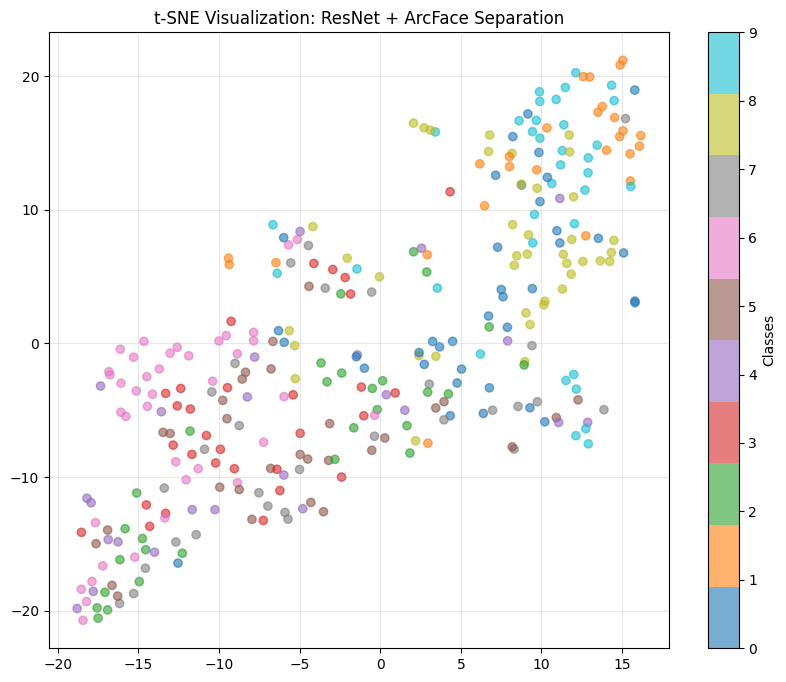

In [8]:
# --- CELL 7: t-SNE VISUALIZATION (Part 3) ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_features(model, loader):
    model.eval()
    features_list = []
    labels_list = []
    
    # We remove the last layer to see the "embedding space"
    # For ResNet, the features are before the final 'fc' layer
    feature_extractor = nn.Sequential(*list(model.children())[:-1])

    print("Extracting features for visualization...")
    
    with torch.no_grad():
        # Only take 5 batches to save time (t-SNE is slow)
        for i, (inputs, labels) in enumerate(loader):
            if i >= 5: break 
            inputs = inputs.to(DEVICE)
            
            # Extract features
            feats = feature_extractor(inputs)
            feats = torch.flatten(feats, 1) # Flatten to vector
            
            features_list.append(feats.cpu().numpy())
            labels_list.append(labels.numpy())

    X = np.concatenate(features_list)
    y = np.concatenate(labels_list)

    print(f"Running t-SNE on {X.shape[0]} samples...")
    # Reduce dimensions from 2048 -> 2
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
    X_tsne = tsne.fit_transform(X)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, ticks=range(10), label='Classes')
    plt.title("t-SNE Visualization: ResNet + ArcFace Separation")
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualize the best performing model (ResNet)
visualize_features(model_3, testloader_large)